# 9章　多値分類

In [1]:
# 必要ライブラリの宣言
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# PDF出力用
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

### データ読み込み

In [3]:
# 学習用データ準備
from sklearn.datasets import load_iris
iris = load_iris()
x_org, y_org = iris.data, iris.target

# 入力データに関しては、sepal length(0)とpetal length(2)のみ抽出
x_select = x_org[:,[0,2]]
print('元データ', x_select.shape, y_org.shape)

元データ (150, 2) (150,)


### 学習データの散布図表示

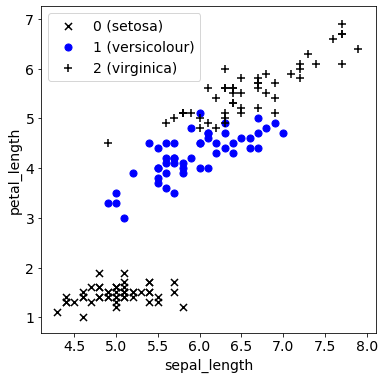

In [4]:
# 散布図の表示
x_t0 = x_select[y_org == 0]
x_t1 = x_select[y_org == 1]
x_t2 = x_select[y_org == 2]
plt.figure(figsize=(6,6))
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length', fontsize=14)
plt.ylabel('petal_length', fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.show()

### データ前処理

In [5]:
# ダミー変数を追加
x_all = np.insert(x_select, 0, 1.0, axis=1)

In [6]:
# yをOne-hot-Vectorに
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False,categories='auto')
y_work = np.c_[y_org]
y_all_one = ohe.fit_transform(y_work)
print('オリジナル', y_org.shape)
print('２次元化', y_work.shape)
print('One Hot Vector化後', y_all_one.shape)

オリジナル (150,)
２次元化 (150, 1)
One Hot Vector化後 (150, 3)


In [7]:
# 学習データ、検証データに分割
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, y_train_one, y_test_one = train_test_split(
    x_all, y_org, y_all_one, train_size=75, test_size=75, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, 
    y_train_one.shape, y_test_one.shape)

(75, 3) (75, 3) (75,) (75,) (75, 3) (75, 3)


In [8]:
print('入力データ(x)')
print(x_train[:5,:])

入力データ(x)
[[1.  6.3 4.7]
 [1.  7.  4.7]
 [1.  5.  1.6]
 [1.  6.4 5.6]
 [1.  6.3 5. ]]


In [9]:
print('正解データ(y)')
print(y_train[:5])

正解データ(y)
[1 1 0 2 2]


In [10]:
print('正解データ (One Hot Vector化後)')
print(y_train_one[:5,:])

正解データ (One Hot Vector化後)
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


### 学習用変数の設定

In [11]:
# 学習対象の選択
x, yt  = x_train, y_train_one

### 予測関数

In [12]:
# softmax関数 (9.7.3)
def softmax(x):
    x = x.T
    x_max = x.max(axis=0)
    x = x - x_max
    w = np.exp(x)
    return (w / w.sum(axis=0)).T

In [13]:
# 予測値の計算 (9.7.1, 9.7.2)
def pred(x, W):
    return softmax(x @ W)

### 評価

In [14]:
# 交差エントロピー関数)(9.5.1)
def cross_entropy(yt, yp):
    return -np.mean(np.sum(yt * np.log(yp), axis=1))

In [15]:
# モデルの評価を行う関数
from sklearn.metrics import accuracy_score

def evaluate(x_test, y_test, y_test_one, W):
    
    # 予測値の計算(確率値)
    yp_test_one = pred(x_test, W)
    
    # 確率値から予測クラス(0, 1, 2)を導出
    yp_test = np.argmax(yp_test_one, axis=1)
    
    # 損失関数値の計算
    loss = cross_entropy(y_test_one, yp_test_one)
    
    # 精度の算出
    score = accuracy_score(y_test, yp_test)
    return loss, score   

### 初期化処理

In [16]:
# 初期化処理

# 標本数
M  = x.shape[0]
# 入力次元数(ダミー変数を含む
D = x.shape[1]
# 分類先クラス数
N = yt.shape[1]

# 繰り返し回数
iters = 10000

# 学習率
alpha = 0.01

# 重み行列の初期設定(すべて1)
W = np.ones((D, N)) 

# 評価結果記録用
history = np.zeros((0, 3))

### メイン処理

In [17]:
#  メイン処理
for k in range(iters):
    
    # 予測値の計算 (9.7.1)　(9.7.2)
    yp = pred(x, W)
    
    # 誤差の計算 (9.7.4)
    yd = yp - yt

    # 重みの更新 (9.7.5)
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_one, W)
        history = np.vstack((history,
            np.array([k, loss, score])))
        print("epoch = %d loss = %f score = %f" 
            % (k, loss, score))

epoch = 0 loss = 1.092628 score = 0.266667
epoch = 10 loss = 1.064035 score = 0.266667
epoch = 20 loss = 1.033466 score = 0.266667
epoch = 30 loss = 1.002645 score = 0.266667
epoch = 40 loss = 0.973510 score = 0.266667
epoch = 50 loss = 0.946309 score = 0.386667
epoch = 60 loss = 0.920978 score = 0.560000
epoch = 70 loss = 0.897402 score = 0.600000
epoch = 80 loss = 0.875452 score = 0.613333
epoch = 90 loss = 0.855005 score = 0.626667
epoch = 100 loss = 0.835942 score = 0.626667
epoch = 110 loss = 0.818152 score = 0.626667
epoch = 120 loss = 0.801532 score = 0.626667
epoch = 130 loss = 0.785986 score = 0.626667
epoch = 140 loss = 0.771424 score = 0.640000
epoch = 150 loss = 0.757767 score = 0.653333
epoch = 160 loss = 0.744941 score = 0.680000
epoch = 170 loss = 0.732877 score = 0.706667
epoch = 180 loss = 0.721513 score = 0.760000
epoch = 190 loss = 0.710795 score = 0.786667
epoch = 200 loss = 0.700670 score = 0.786667
epoch = 210 loss = 0.691092 score = 0.800000
epoch = 220 loss = 0.

epoch = 2240 loss = 0.341162 score = 0.946667
epoch = 2250 loss = 0.340631 score = 0.946667
epoch = 2260 loss = 0.340103 score = 0.946667
epoch = 2270 loss = 0.339577 score = 0.946667
epoch = 2280 loss = 0.339054 score = 0.946667
epoch = 2290 loss = 0.338533 score = 0.946667
epoch = 2300 loss = 0.338015 score = 0.946667
epoch = 2310 loss = 0.337500 score = 0.946667
epoch = 2320 loss = 0.336987 score = 0.946667
epoch = 2330 loss = 0.336477 score = 0.946667
epoch = 2340 loss = 0.335969 score = 0.946667
epoch = 2350 loss = 0.335463 score = 0.946667
epoch = 2360 loss = 0.334960 score = 0.946667
epoch = 2370 loss = 0.334460 score = 0.946667
epoch = 2380 loss = 0.333962 score = 0.946667
epoch = 2390 loss = 0.333466 score = 0.946667
epoch = 2400 loss = 0.332973 score = 0.946667
epoch = 2410 loss = 0.332482 score = 0.946667
epoch = 2420 loss = 0.331994 score = 0.946667
epoch = 2430 loss = 0.331507 score = 0.946667
epoch = 2440 loss = 0.331023 score = 0.946667
epoch = 2450 loss = 0.330542 score

epoch = 4220 loss = 0.270291 score = 0.960000
epoch = 4230 loss = 0.270050 score = 0.960000
epoch = 4240 loss = 0.269809 score = 0.960000
epoch = 4250 loss = 0.269569 score = 0.960000
epoch = 4260 loss = 0.269330 score = 0.960000
epoch = 4270 loss = 0.269091 score = 0.960000
epoch = 4280 loss = 0.268854 score = 0.960000
epoch = 4290 loss = 0.268617 score = 0.960000
epoch = 4300 loss = 0.268380 score = 0.960000
epoch = 4310 loss = 0.268145 score = 0.960000
epoch = 4320 loss = 0.267910 score = 0.960000
epoch = 4330 loss = 0.267676 score = 0.960000
epoch = 4340 loss = 0.267443 score = 0.960000
epoch = 4350 loss = 0.267211 score = 0.960000
epoch = 4360 loss = 0.266979 score = 0.960000
epoch = 4370 loss = 0.266748 score = 0.960000
epoch = 4380 loss = 0.266518 score = 0.960000
epoch = 4390 loss = 0.266288 score = 0.960000
epoch = 4400 loss = 0.266060 score = 0.960000
epoch = 4410 loss = 0.265831 score = 0.960000
epoch = 4420 loss = 0.265604 score = 0.960000
epoch = 4430 loss = 0.265378 score

epoch = 6670 loss = 0.227853 score = 0.960000
epoch = 6680 loss = 0.227729 score = 0.960000
epoch = 6690 loss = 0.227605 score = 0.960000
epoch = 6700 loss = 0.227482 score = 0.960000
epoch = 6710 loss = 0.227359 score = 0.960000
epoch = 6720 loss = 0.227236 score = 0.960000
epoch = 6730 loss = 0.227113 score = 0.960000
epoch = 6740 loss = 0.226991 score = 0.960000
epoch = 6750 loss = 0.226869 score = 0.960000
epoch = 6760 loss = 0.226747 score = 0.960000
epoch = 6770 loss = 0.226626 score = 0.960000
epoch = 6780 loss = 0.226505 score = 0.960000
epoch = 6790 loss = 0.226384 score = 0.960000
epoch = 6800 loss = 0.226263 score = 0.960000
epoch = 6810 loss = 0.226143 score = 0.960000
epoch = 6820 loss = 0.226022 score = 0.960000
epoch = 6830 loss = 0.225903 score = 0.960000
epoch = 6840 loss = 0.225783 score = 0.960000
epoch = 6850 loss = 0.225664 score = 0.960000
epoch = 6860 loss = 0.225545 score = 0.960000
epoch = 6870 loss = 0.225426 score = 0.960000
epoch = 6880 loss = 0.225307 score

epoch = 9160 loss = 0.203785 score = 0.960000
epoch = 9170 loss = 0.203710 score = 0.960000
epoch = 9180 loss = 0.203634 score = 0.960000
epoch = 9190 loss = 0.203559 score = 0.960000
epoch = 9200 loss = 0.203484 score = 0.960000
epoch = 9210 loss = 0.203410 score = 0.960000
epoch = 9220 loss = 0.203335 score = 0.960000
epoch = 9230 loss = 0.203260 score = 0.960000
epoch = 9240 loss = 0.203186 score = 0.960000
epoch = 9250 loss = 0.203112 score = 0.960000
epoch = 9260 loss = 0.203037 score = 0.960000
epoch = 9270 loss = 0.202963 score = 0.960000
epoch = 9280 loss = 0.202889 score = 0.960000
epoch = 9290 loss = 0.202816 score = 0.960000
epoch = 9300 loss = 0.202742 score = 0.960000
epoch = 9310 loss = 0.202668 score = 0.960000
epoch = 9320 loss = 0.202595 score = 0.960000
epoch = 9330 loss = 0.202522 score = 0.960000
epoch = 9340 loss = 0.202449 score = 0.960000
epoch = 9350 loss = 0.202376 score = 0.960000
epoch = 9360 loss = 0.202303 score = 0.960000
epoch = 9370 loss = 0.202230 score

### 結果確認

In [18]:
#損失関数値と精度の確認
print('初期状態: 損失関数:%f 精度:%f' 
    % (history[0,1], history[0,2]))
print('最終状態: 損失関数:%f 精度:%f' 
    % (history[-1,1], history[-1,2]))

初期状態: 損失関数:1.092628 精度:0.266667
最終状態: 損失関数:0.197948 精度:0.960000


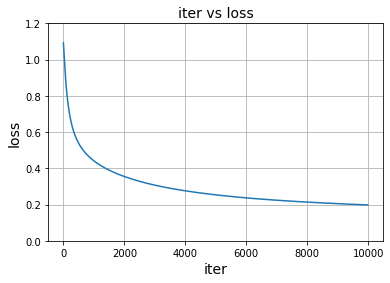

In [19]:
# 学習曲線の表示 (損失関数)
plt.plot(history[:,0], history[:,1])
plt.grid()
plt.ylim(0,1.2)
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('iter vs loss', fontsize=14)
plt.show()

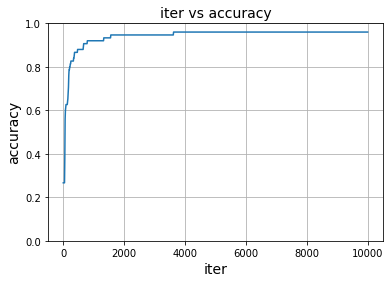

In [20]:
# 学習曲線の表示 (精度)
plt.plot(history[:,0], history[:,2])
plt.ylim(0,1)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()

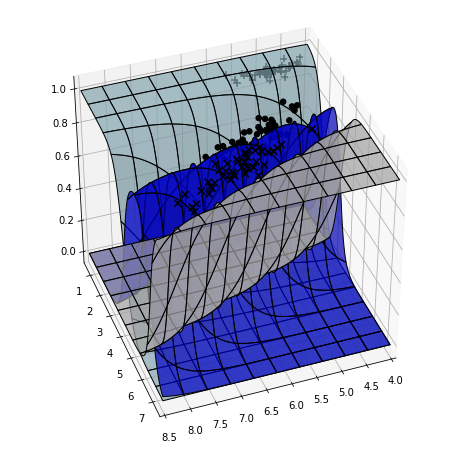

In [21]:
# 3次元表示
from mpl_toolkits.mplot3d import Axes3D
x1 = np.linspace(4, 8.5, 100)
x2 = np.linspace(0.5, 7.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xxx = np.array([np.ones(xx1.ravel().shape), 
    xx1.ravel(), xx2.ravel()]).T
pp = pred(xxx, W)
c0 = pp[:,0].reshape(xx1.shape)
c1 = pp[:,1].reshape(xx1.shape)
c2 = pp[:,2].reshape(xx1.shape)
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx1, xx2, c0, color='lightblue', 
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c1, color='blue', 
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c2, color='lightgrey', 
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.scatter(x_t0[:,0], x_t0[:,1], 1, s=50, alpha=1, marker='+', c='k')
ax.scatter(x_t1[:,0], x_t1[:,1], 1, s=30, alpha=1, marker='o', c='k')
ax.scatter(x_t2[:,0], x_t2[:,1], 1, s=50, alpha=1, marker='x', c='k')
ax.set_xlim(4,8.5)
ax.set_ylim(0.5,7.5)
ax.view_init(elev=40, azim=70)

In [22]:
# 評価
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# テストデータで予測値の計算
yp_test_one = pred(x_test, W)
yp_test = np.argmax(yp_test_one, axis=1)

#  精度の計算
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, yp_test)
print('accuracy: %f' % score)

# 混同行列の表示
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, yp_test))
print(classification_report(y_test, yp_test))

accuracy: 0.960000
[[27  0  0]
 [ 0 20  0]
 [ 0  3 25]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.87      1.00      0.93        20
           2       1.00      0.89      0.94        28

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.97      0.96      0.96        75



# 入力変数を4次元に変更

In [23]:
# ダミー変数を追加
x_all2 = np.insert(x_org, 0, 1.0, axis=1)

In [24]:
# 学習データ、検証データに分割
from sklearn.model_selection import train_test_split

x_train2, x_test2, y_train, y_test,\
y_train_one, y_test_one = train_test_split(
    x_all2, y_org, y_all_one, train_size=75, 
    test_size=75, random_state=123)
print(x_train2.shape, x_test2.shape, 
    y_train.shape, y_test.shape, 
    y_train_one.shape, y_test_one.shape)

(75, 5) (75, 5) (75,) (75,) (75, 3) (75, 3)


In [25]:
print('入力データ(x)')
print(x_train2[:5,:])

入力データ(x)
[[1.  6.3 3.3 4.7 1.6]
 [1.  7.  3.2 4.7 1.4]
 [1.  5.  3.  1.6 0.2]
 [1.  6.4 2.8 5.6 2.1]
 [1.  6.3 2.5 5.  1.9]]


In [26]:
# 学習対象の選択
x, yt, x_test  = x_train2, y_train_one, x_test2

In [27]:
# 初期化処理

# 標本数
M  = x.shape[0]
# 入力次元数(ダミー変数を含む
D = x.shape[1]
# 分類先クラス数
N = yt.shape[1]

# 繰り返し回数
iters = 10000

# 学習率
alpha = 0.01

# 重み行列の初期設定(すべて1)
W = np.ones((D, N)) 

# 評価結果記録用
history = np.zeros((0, 3))

In [28]:
#  メイン処理(４次元版)
for k in range(iters):
    
    # 予測値の計算 (9.7.1)　(9.7.2)
    yp = pred(x, W)
    
    # 誤差の計算 (9.7.4)
    yd = yp - yt

    # 重みの更新 (9.7.5)
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_one, W)
        history = np.vstack((history, np.array([k, loss, score])))
        print("epoch = %d loss = %f score = %f" % (k, loss, score))

epoch = 0 loss = 1.091583 score = 0.266667
epoch = 10 loss = 1.041711 score = 0.266667
epoch = 20 loss = 0.988501 score = 0.266667
epoch = 30 loss = 0.939962 score = 0.573333
epoch = 40 loss = 0.897037 score = 0.626667
epoch = 50 loss = 0.859177 score = 0.626667
epoch = 60 loss = 0.825724 score = 0.626667
epoch = 70 loss = 0.796070 score = 0.626667
epoch = 80 loss = 0.769683 score = 0.653333
epoch = 90 loss = 0.746103 score = 0.653333
epoch = 100 loss = 0.724936 score = 0.693333
epoch = 110 loss = 0.705850 score = 0.746667
epoch = 120 loss = 0.688561 score = 0.760000
epoch = 130 loss = 0.672832 score = 0.760000
epoch = 140 loss = 0.658461 score = 0.786667
epoch = 150 loss = 0.645275 score = 0.786667
epoch = 160 loss = 0.633131 score = 0.786667
epoch = 170 loss = 0.621903 score = 0.813333
epoch = 180 loss = 0.611485 score = 0.813333
epoch = 190 loss = 0.601788 score = 0.840000
epoch = 200 loss = 0.592731 score = 0.840000
epoch = 210 loss = 0.584248 score = 0.880000
epoch = 220 loss = 0.

epoch = 2300 loss = 0.256163 score = 0.960000
epoch = 2310 loss = 0.255666 score = 0.960000
epoch = 2320 loss = 0.255172 score = 0.960000
epoch = 2330 loss = 0.254681 score = 0.960000
epoch = 2340 loss = 0.254193 score = 0.960000
epoch = 2350 loss = 0.253707 score = 0.960000
epoch = 2360 loss = 0.253224 score = 0.960000
epoch = 2370 loss = 0.252744 score = 0.960000
epoch = 2380 loss = 0.252267 score = 0.960000
epoch = 2390 loss = 0.251792 score = 0.960000
epoch = 2400 loss = 0.251320 score = 0.960000
epoch = 2410 loss = 0.250850 score = 0.960000
epoch = 2420 loss = 0.250383 score = 0.960000
epoch = 2430 loss = 0.249919 score = 0.960000
epoch = 2440 loss = 0.249457 score = 0.960000
epoch = 2450 loss = 0.248998 score = 0.960000
epoch = 2460 loss = 0.248542 score = 0.960000
epoch = 2470 loss = 0.248087 score = 0.960000
epoch = 2480 loss = 0.247636 score = 0.960000
epoch = 2490 loss = 0.247187 score = 0.960000
epoch = 2500 loss = 0.246740 score = 0.960000
epoch = 2510 loss = 0.246296 score

epoch = 4380 loss = 0.191369 score = 0.960000
epoch = 4390 loss = 0.191175 score = 0.960000
epoch = 4400 loss = 0.190982 score = 0.960000
epoch = 4410 loss = 0.190789 score = 0.960000
epoch = 4420 loss = 0.190597 score = 0.960000
epoch = 4430 loss = 0.190405 score = 0.960000
epoch = 4440 loss = 0.190215 score = 0.960000
epoch = 4450 loss = 0.190025 score = 0.960000
epoch = 4460 loss = 0.189835 score = 0.960000
epoch = 4470 loss = 0.189647 score = 0.960000
epoch = 4480 loss = 0.189459 score = 0.960000
epoch = 4490 loss = 0.189271 score = 0.960000
epoch = 4500 loss = 0.189085 score = 0.960000
epoch = 4510 loss = 0.188899 score = 0.960000
epoch = 4520 loss = 0.188713 score = 0.960000
epoch = 4530 loss = 0.188529 score = 0.960000
epoch = 4540 loss = 0.188345 score = 0.960000
epoch = 4550 loss = 0.188161 score = 0.960000
epoch = 4560 loss = 0.187978 score = 0.960000
epoch = 4570 loss = 0.187796 score = 0.960000
epoch = 4580 loss = 0.187615 score = 0.960000
epoch = 4590 loss = 0.187434 score

epoch = 6810 loss = 0.158541 score = 0.960000
epoch = 6820 loss = 0.158447 score = 0.960000
epoch = 6830 loss = 0.158353 score = 0.960000
epoch = 6840 loss = 0.158260 score = 0.960000
epoch = 6850 loss = 0.158167 score = 0.960000
epoch = 6860 loss = 0.158074 score = 0.960000
epoch = 6870 loss = 0.157982 score = 0.960000
epoch = 6880 loss = 0.157890 score = 0.960000
epoch = 6890 loss = 0.157797 score = 0.960000
epoch = 6900 loss = 0.157706 score = 0.960000
epoch = 6910 loss = 0.157614 score = 0.960000
epoch = 6920 loss = 0.157523 score = 0.960000
epoch = 6930 loss = 0.157431 score = 0.960000
epoch = 6940 loss = 0.157341 score = 0.960000
epoch = 6950 loss = 0.157250 score = 0.960000
epoch = 6960 loss = 0.157159 score = 0.960000
epoch = 6970 loss = 0.157069 score = 0.960000
epoch = 6980 loss = 0.156979 score = 0.960000
epoch = 6990 loss = 0.156889 score = 0.960000
epoch = 7000 loss = 0.156800 score = 0.960000
epoch = 7010 loss = 0.156710 score = 0.960000
epoch = 7020 loss = 0.156621 score

epoch = 9100 loss = 0.141862 score = 0.960000
epoch = 9110 loss = 0.141806 score = 0.960000
epoch = 9120 loss = 0.141750 score = 0.960000
epoch = 9130 loss = 0.141693 score = 0.960000
epoch = 9140 loss = 0.141637 score = 0.960000
epoch = 9150 loss = 0.141581 score = 0.960000
epoch = 9160 loss = 0.141525 score = 0.960000
epoch = 9170 loss = 0.141469 score = 0.960000
epoch = 9180 loss = 0.141414 score = 0.960000
epoch = 9190 loss = 0.141358 score = 0.960000
epoch = 9200 loss = 0.141303 score = 0.960000
epoch = 9210 loss = 0.141247 score = 0.960000
epoch = 9220 loss = 0.141192 score = 0.960000
epoch = 9230 loss = 0.141137 score = 0.960000
epoch = 9240 loss = 0.141082 score = 0.960000
epoch = 9250 loss = 0.141027 score = 0.960000
epoch = 9260 loss = 0.140972 score = 0.960000
epoch = 9270 loss = 0.140917 score = 0.960000
epoch = 9280 loss = 0.140863 score = 0.960000
epoch = 9290 loss = 0.140808 score = 0.960000
epoch = 9300 loss = 0.140754 score = 0.960000
epoch = 9310 loss = 0.140699 score

In [29]:
print(history.shape)

(1000, 3)


In [30]:
#損失関数値と精度の確認
print('初期状態: 損失関数:%f 精度:%f' 
    % (history[0,1], history[0,2]))
print('最終状態: 損失関数:%f 精度:%f' 
    % (history[-1,1], history[-1,2]))

初期状態: 損失関数:1.091583 精度:0.266667
最終状態: 損失関数:0.137235 精度:0.960000


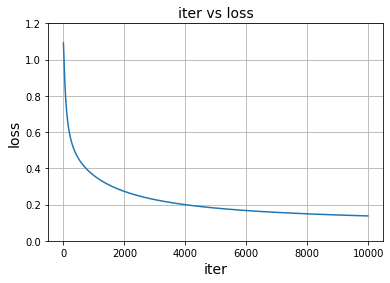

In [31]:
# 学習曲線の表示 (損失関数)
plt.plot(history[:,0], history[:,1])
plt.ylim(0,1.2)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('iter vs loss', fontsize=14)
plt.show()

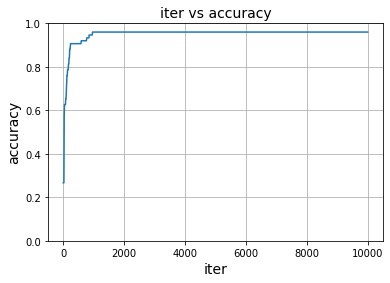

In [32]:
# 学習曲線の表示 (精度)
plt.plot(history[:,0], history[:,2])
plt.ylim(0,1)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()